# Generate PSF from Aditya's beads

by Pu Zheng

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

44872


## local packages

In [3]:
from ImageAnalysis3.io_tools.load import correct_fov_image
from ImageAnalysis3.io_tools.crop import crop_neighboring_area

## load images

In [4]:
# load fov image
data_folder = r'\\10.245.74.158\Chromatin_NAS_5\20210618-Beads_PSF'
folders, fovs = io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 1
- Number of field of views: 25


In [5]:
# select a file
folder_id = 0
fov_id = 3
input_file = os.path.join(folders[folder_id], fovs[fov_id])

In [7]:
all_channels = [750,647,561,488,405]

ims, _ = correct_fov_image(
    input_file, all_channels,
    single_im_size=[60,2048,2048],
    drift_channel='561', corr_channels=[750,647,561],
    all_channels=all_channels,
    num_empty_frames=0, num_buffer_frames=0,
    correction_folder=r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
    calculate_drift=False, warp_image=False,
    illumination_corr=False, chromatic_corr=False, bleed_corr=False, z_shift_corr=False, hot_pixel_corr=True,
)

os.path.join(input_file)

- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210618-Beads_PSF\H0R0\Conv_zscan_03.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210618-Beads_PSF\H0R0\Conv_zscan_03.dax  in 9.470s
-- removing hot pixels for channels:['750', '647', '561', '488', '405'] in 102.299s
-- -- generate translation function with drift:[0. 0. 0.] in 0.001s
-- finish correction in 116.227s


'\\\\10.245.74.158\\Chromatin_NAS_5\\20210618-Beads_PSF\\H0R0\\Conv_zscan_03.dax'

## visualize

<IPython.core.display.Javascript object>


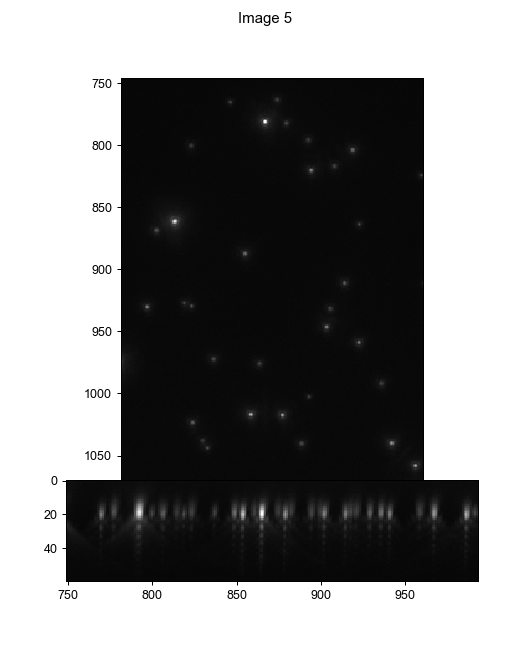

In [8]:
visual_tools.imshow_mark_3d_v2(ims)

In [9]:
from ImageAnalysis3.spot_tools.fitting import fit_fov_image, get_seeds

In [18]:
## get seeds
spots_list = [fit_fov_image(ims[ch_id], all_channels[ch_id], 
                            max_num_seeds=2000, use_percentile=True, 
                            th_seed_per=99.,) for ch_id in range(len(ims))]

-- start fitting spots in channel:750, 363 seeded, 363 fitted in 159.960s.
-- start fitting spots in channel:647, 1000 seeded, 

E:\Users\puzheng\AppData\anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
E:\Users\puzheng\Documents\ImageAnalysis3\External\Fitting_v4.py:285: RuntimeWarning: overflow encountered in exp
  self.f = np.exp(bk)+self.f0


1000 fitted in 193.801s.
-- start fitting spots in channel:561, 1000 seeded, 1000 fitted in 192.954s.
-- start fitting spots in channel:488, 1000 seeded, 1000 fitted in 184.387s.
-- start fitting spots in channel:405, 1000 seeded, 1000 fitted in 166.211s.


In [52]:
def select_sparse_xy(spots, min_distance=10, distance_order=np.inf, 
                     remove_overlap_z=True, overlap_z_dist=1,
                     verbose=False):
    _sorted_spots = spots.copy()
    _sorted_spots = _sorted_spots[np.flipud(np.argsort(_sorted_spots[:,0]))]
    # select spots
    _sel_spots = [_sorted_spots[0]]
    for _i, _spot in enumerate(_sorted_spots[1:]):
        # calculate distance
        _xy_dists = np.linalg.norm((np.array(_sel_spots)-_spot)[:,2:4], axis=1, ord=distance_order)
        # skip spot if overlapping in z
        if remove_overlap_z and np.min(_xy_dists) <= overlap_z_dist:
            if verbose:
                print(f"skip spot {_i+1} by overlapping xy distance threshold")
            continue
        # skip spot if zxy is too close
        _zxy_dists = np.linalg.norm((np.array(_sel_spots)-_spot)[:,1:4], axis=1, ord=distance_order)
        if np.min(_zxy_dists) <= min_distance:
            if verbose:
                print(f"skip spot {_i+1} by distance threshold")
            continue
        
        # otherwise, keep this spot
        _sel_spots.append(_spot)
        
        
            
    return np.array(_sel_spots)

In [54]:
sel_spots = select_sparse_xy(spots_list[0], verbose=True)

skip spot 17 by overlapping xy distance threshold
skip spot 213 by distance threshold
skip spot 282 by distance threshold
skip spot 288 by overlapping xy distance threshold
skip spot 296 by distance threshold
skip spot 313 by distance threshold
skip spot 315 by overlapping xy distance threshold
skip spot 337 by overlapping xy distance threshold
skip spot 350 by distance threshold
skip spot 353 by distance threshold
skip spot 356 by overlapping xy distance threshold
skip spot 358 by overlapping xy distance threshold
skip spot 359 by overlapping xy distance threshold
skip spot 360 by distance threshold
skip spot 361 by distance threshold
skip spot 362 by distance threshold


In [283]:
dist_th = 31
ch_id = 0
sel_crops = [crop_neighboring_area(ims[ch_id], _spot[1:4], dist_th) for _spot in select_sparse_xy(spots_list[ch_id], dist_th)]

In [284]:
psf = np.mean([_c/np.sum(_c) for _c in sel_crops], axis=0)

<IPython.core.display.Javascript object>


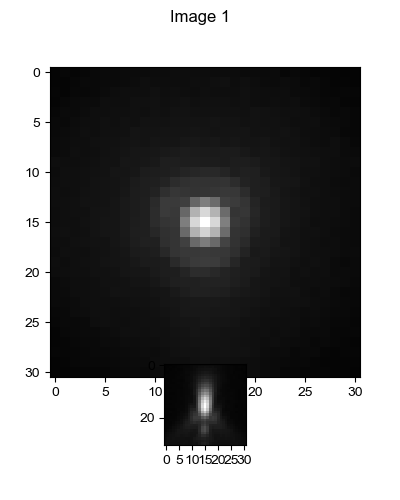

In [285]:
visual_tools.imshow_mark_3d_v2([np.mean(sel_crops, axis=0)])

In [286]:
from skimage.restoration import richardson_lucy
crop = (slice(0,60), slice(270,430), slice(270,430))


<IPython.core.display.Javascript object>


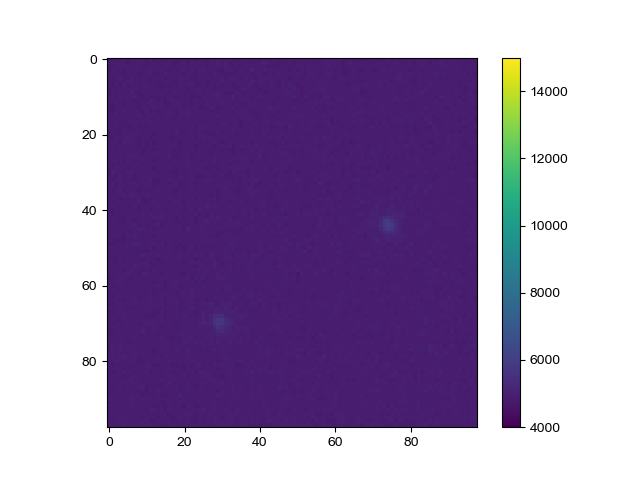

In [287]:
plt.figure()
plt.imshow(ims[ch_id][crop][:,dist_th:-dist_th,dist_th:-dist_th].max(0), vmin=4000, vmax=15000)
plt.colorbar()
plt.show()

In [288]:
padded_im = ims[ch_id][crop]
padded_im = np.concatenate([np.ones(np.shape(padded_im))*np.median(padded_im), 
                            padded_im, 
                            np.ones(np.shape(padded_im))*np.median(padded_im),])

decon_im = richardson_lucy(padded_im, psf, clip=False, iterations=20, )

<IPython.core.display.Javascript object>


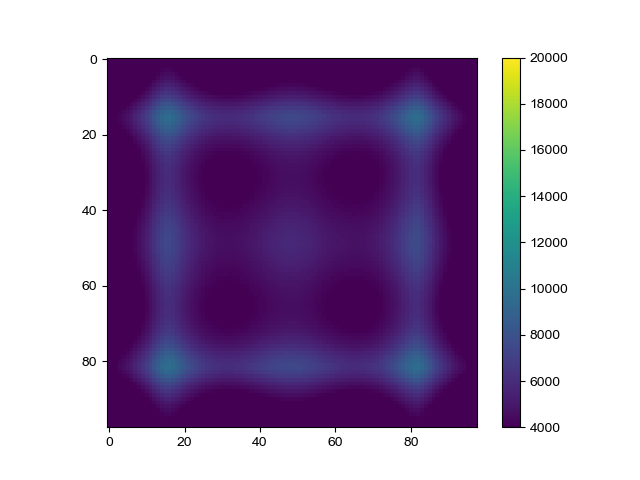

In [290]:
plt.figure()
plt.imshow(decon_im[60:-60,dist_th:-dist_th,dist_th:-dist_th].max(0), vmin=4000, vmax=20000)#[16:-16,16:-16])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


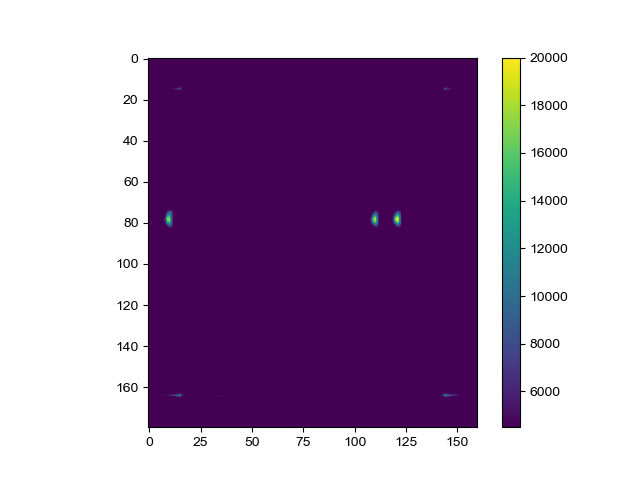

In [282]:
plt.figure()
plt.imshow(decon_im.mean(1), vmin=4500, vmax=20000)
plt.colorbar()
plt.show()

In [220]:
# load test data
test_data_folder = r'\\10.245.74.158\Chromatin_NAS_5\20210617-Thymus_IF_RNA'
test_folders, test_fovs = io_tools.data.get_folders(test_data_folder)
# select a file
test_folder_id = 1
test_fov_id = 18
test_file = os.path.join(test_folders[test_folder_id], test_fovs[test_fov_id])

test_channels = [750,647,488,405]

test_ims, _ = correct_fov_image(
    test_file, test_channels,
    single_im_size=[60,2048,2048],
    drift_channel='488', corr_channels=[750,647],
    all_channels=test_channels,
    num_empty_frames=0, num_buffer_frames=0,
    correction_folder=r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201204-Corrections_3color_50',
    calculate_drift=False, warp_image=False,
    illumination_corr=False, chromatic_corr=False, bleed_corr=False, z_shift_corr=True, hot_pixel_corr=False,
)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 6
- Number of field of views: 20
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_5\20210617-Thymus_IF_RNA\H0R0\Conv_zscan_18.dax
-- loading image from file:\\10.245.74.158\Chromatin_NAS_5\20210617-Thymus_IF_RNA\H0R0\Conv_zscan_18.dax  in 6.712s
-- correct Z-shifts for channels:['750', '647', '488', '405'] in 52.349s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 62.878s


<IPython.core.display.Javascript object>


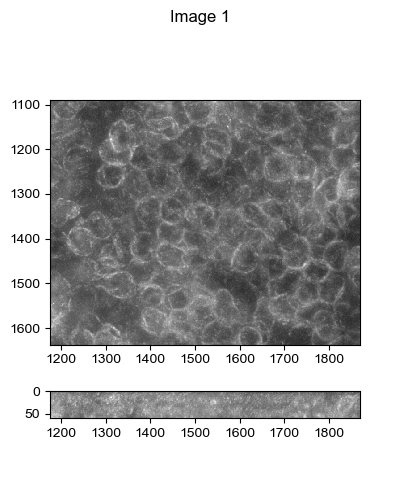

In [221]:
visual_tools.imshow_mark_3d_v2(test_ims)

In [213]:
ch_id = 0

In [222]:
from skimage.restoration import richardson_lucy
crop = (slice(0,60), slice(1300,1500), slice(1300,1500))

<IPython.core.display.Javascript object>


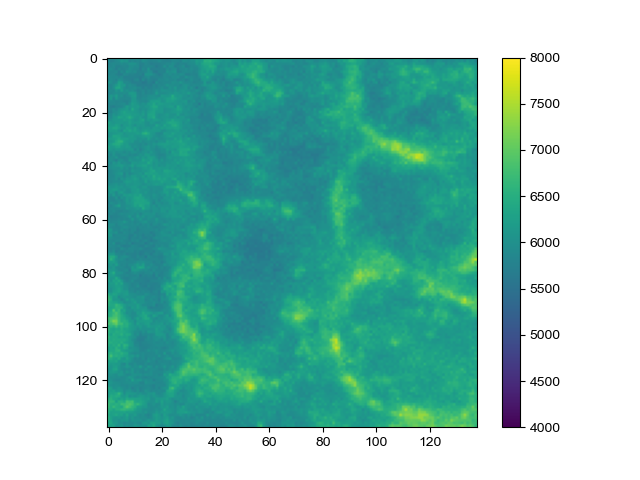

In [224]:
plt.figure()
plt.imshow(test_ims[ch_id][crop][:,dist_th:-dist_th,dist_th:-dist_th].max(0), vmin=4000, vmax=8000)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


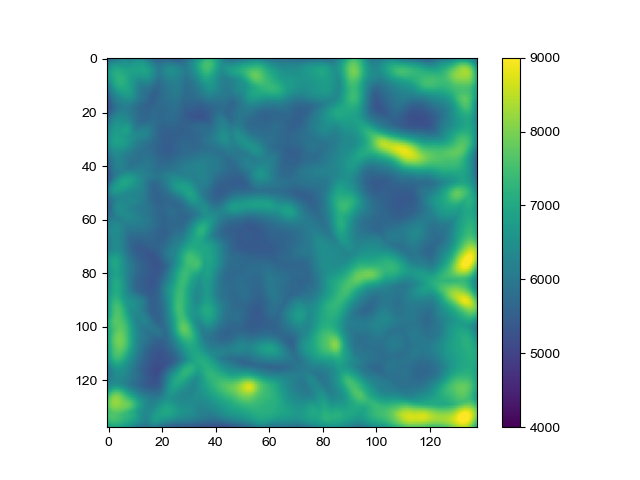

In [227]:
plt.figure()
plt.imshow(decon_im[60:-60,dist_th:-dist_th,dist_th:-dist_th].max(0), vmin=4000, vmax=9000)#[16:-16,16:-16])
plt.colorbar()
plt.show()

In [225]:
padded_im = test_ims[ch_id][crop]
padded_im = np.concatenate([np.ones(np.shape(padded_im))*np.median(padded_im), 
                            padded_im, 
                            np.ones(np.shape(padded_im))*np.median(padded_im),])

decon_im = richardson_lucy(padded_im, psf, clip=False, iterations=20, )

In [187]:
from skimage.restoration import richardson_lucy
crop = (slice(0,60), slice(1200,1500), slice(1200,1500))

decon_im = richardson_lucy(test_ims[ch_id][crop].astype(np.float), psf, clip=False, iterations=10, )

<IPython.core.display.Javascript object>


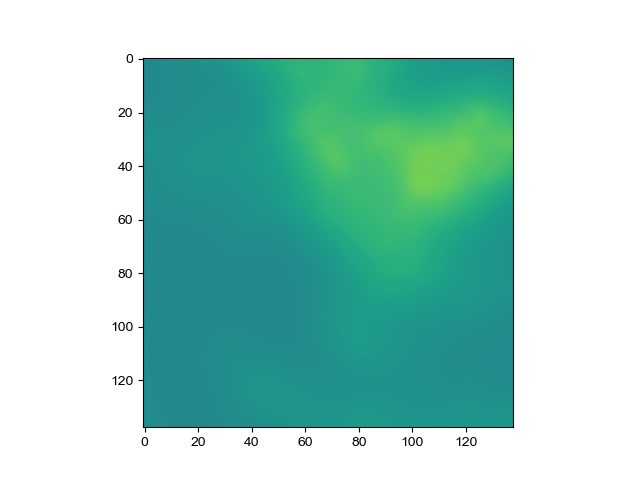

In [201]:
plt.figure()
plt.imshow(decon_im[60:-60,dist_th:-dist_th,dist_th:-dist_th].max(0), vmin=3000, vmax=7000)#[16:-16,16:-16])

<IPython.core.display.Javascript object>


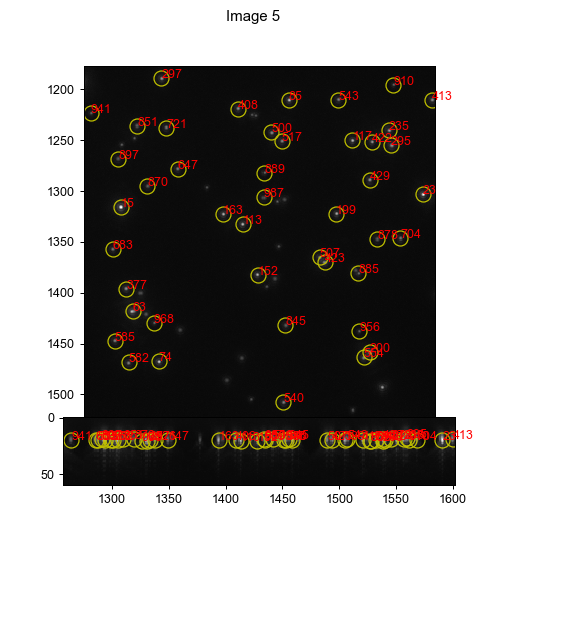

In [27]:
## visualize

#coord_dict = {'coords':[np.flipud(_spot[1:4]) for _spot in spots],
#              'class_ids':list(np.zeros(len(spots),dtype=np.int)),
#             }

coord_dict = {'coords':np.concatenate([np.fliplr(_spots[:,1:4]) for _spots in spots_list]),
              'class_ids':np.concatenate([np.ones(len(_spots),dtype=np.int32)*_i for _i,_spots in enumerate(spots_list)]),
             }

visual_tools.imshow_mark_3d_v2(ims, 
                               given_dic=coord_dict,
                               save_file=None,
                               )
